In [59]:
# Import
import os
from PIL import Image

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

# 학습 데이터

In [4]:
# 데이터 로드
emis_ctrl_2013 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2013.csv', index_col=0)
emis_ctrl_2019 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2019.csv', index_col=0)
sector_ctrl_2013 = pd.read_csv('/home/user/workdir/main/resources/ctrl/sector_control_2013.csv', index_col=0)
conc_data_2019_05 = []
with nc.Dataset('/home/user/workdir/main/datasets/concentration/2019/0.50/ACONC.1') as f:
    conc_data_2019_05 = f.variables['PM2_5'][:].data.squeeze() # netCDF 파일 중 PM2_5 데이터 추출 (82x67)

In [5]:
emis_ctrl_2013 # 119개의 데이터는 (17*5) 크기만큼의 속성을 가짐, 2013년도 전구물질 배출량 (from CMAQ Simulation)

,A_NOX_ALL,A_SO2_ALL,A_VOC_ALL,A_NH3_ALL,A_PM25_ALL,B_NOX_ALL,B_SO2_ALL,B_VOC_ALL,B_NH3_ALL,B_PM25_ALL,...,P_NOX_ALL,P_SO2_ALL,P_VOC_ALL,P_NH3_ALL,P_PM25_ALL,Q_NOX_ALL,Q_SO2_ALL,Q_VOC_ALL,Q_NH3_ALL,Q_PM25_ALL
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.871163,0.751879,1.241296,1.241296,0.837620,0.869528,0.796421,1.008703,1.008703,0.962915,...,0.866257,0.940154,1.120186,1.120186,0.902149,0.671272,1.139134,1.024438,1.024438,1.328682
3,0.734821,0.934779,0.647231,0.647231,0.982618,1.188854,0.832964,1.000202,1.000202,0.780403,...,1.278162,1.388087,1.284456,1.284456,1.433464,1.127691,0.764985,0.865993,0.865993,1.294374
4,1.234901,0.870514,1.263537,1.263537,0.900073,0.955756,1.146775,0.971038,0.971038,0.906025,...,0.991836,1.010911,1.163405,1.163405,1.079142,1.140885,1.080571,1.275085,1.275085,0.767802
5,0.806340,1.019923,0.734720,0.734720,0.640250,1.090280,0.986776,1.147626,1.147626,1.188045,...,1.093813,0.945476,0.869924,0.869924,0.953224,1.194511,1.317056,0.770811,0.770811,1.123753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.649676,0.703828,1.279131,1.279131,1.167864,1.334521,1.126091,0.679807,0.679807,0.718116,...,0.902038,1.043914,1.079737,1.079737,1.119276,1.264937,1.163908,0.790256,0.790256,0.921121
116,0.974798,0.713999,0.671351,0.671351,1.236281,0.850271,0.920345,0.916459,0.916459,1.087031,...,0.931988,0.698988,0.875252,0.875252,0.698483,1.104828,1.233427,0.995660,0.995660,0.653914
117,0.886244,1.013323,1.100741,1.100741,1.004096,0.619206,0.832290,0.974206,0.974206,0.975765,...,1.127766,0.951570,0.879320,0.879320,0.863123,1.264807,0.936086,1.031716,1.031716,1.178222
118,0.892489,1.018880,0.816186,0.816186,0.881785,0.916137,0.882454,0.945854,0.945854,1.115611,...,0.974250,1.016576,1.112362,1.112362,0.992612,1.252752,1.295483,1.158895,1.158895,1.272655


In [6]:
emis_ctrl_2019 # 119개의 데이터는 (17*5) 크기만큼의 속성을 가짐, 2019년도 전구물질 배출량 (from CMAQ Simulation)

,A_NOX_ALL,A_SO2_ALL,A_VOC_ALL,A_NH3_ALL,A_PM25_ALL,B_NOX_ALL,B_SO2_ALL,B_VOC_ALL,B_NH3_ALL,B_PM25_ALL,...,P_NOX_ALL,P_SO2_ALL,P_VOC_ALL,P_NH3_ALL,P_PM25_ALL,Q_NOX_ALL,Q_SO2_ALL,Q_VOC_ALL,Q_NH3_ALL,Q_PM25_ALL
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.863536,0.700099,1.241056,0.833703,0.812254,0.869754,0.796407,1.006564,0.962918,0.803118,...,0.870206,0.941031,1.121575,0.902626,0.901955,0.657383,1.139638,1.010165,1.315283,0.591438
3,0.742006,0.983985,0.646946,0.986340,0.956668,1.192631,0.832971,1.003773,0.780494,1.093660,...,1.278780,1.388193,1.284151,1.433524,1.372564,1.120913,0.763423,0.824734,1.290492,1.083136
4,1.242453,0.920476,1.263960,0.903860,1.061871,0.955693,1.146790,0.973506,0.906026,1.028232,...,0.993028,1.011176,1.163494,1.079287,1.086030,1.145995,1.079256,1.265949,0.777755,1.212820
5,0.814413,1.074629,0.735800,0.644385,0.682861,1.089342,0.986736,1.144006,1.188025,1.196274,...,1.094224,0.945197,0.868594,0.953091,1.067506,1.196717,1.317486,0.776720,1.122029,1.126078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.637726,0.623853,1.277424,1.161813,0.999322,1.338111,1.126068,0.680149,0.718203,1.227260,...,0.898629,1.043560,1.078804,1.119066,0.995012,1.270025,1.163085,0.775742,0.922857,1.157404
116,0.964623,0.645136,0.669842,1.231076,1.175551,0.848685,0.920326,0.912572,1.086990,0.827799,...,0.928756,0.698272,0.873848,0.698095,0.824039,1.115707,1.233914,1.026594,0.664581,1.191756
117,0.878997,0.964736,1.100528,1.000417,0.917413,0.616271,0.832265,0.970286,0.975696,0.753872,...,1.132273,0.952019,0.881093,0.863391,1.007772,1.264429,0.935599,1.006009,1.170412,1.044425
118,0.894946,1.035694,0.816513,0.883055,0.879394,0.915738,0.882485,0.947299,1.115599,0.836046,...,0.975411,1.017024,1.113508,0.992845,0.975551,1.253173,1.295791,1.164553,1.272193,1.253177


In [7]:
sector_ctrl_2013 # 119개의 데이터는 (17*7) 크기만큼의 속성을 가짐

,A_ALL_POW,A_ALL_IND,A_ALL_MOB,A_ALL_RES,A_NH3_AGR,A_ALL_SLV,A_ALL_OTH,B_ALL_POW,B_ALL_IND,B_ALL_MOB,...,P_NH3_AGR,P_ALL_SLV,P_ALL_OTH,Q_ALL_POW,Q_ALL_IND,Q_ALL_MOB,Q_ALL_RES,Q_NH3_AGR,Q_ALL_SLV,Q_ALL_OTH
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.514472,0.927851,0.945247,0.692404,1.109061,1.314118,0.721184,0.611804,1.087023,0.949001,...,0.534377,1.445089,1.468231,0.996659,1.394900,0.549501,0.787085,1.343032,1.208780,0.512756
3,1.491511,1.186824,0.617696,0.980489,0.584264,0.633402,1.262937,0.667709,0.727940,1.381620,...,1.111289,0.882215,1.439387,0.983968,0.804134,1.274939,0.507539,1.309304,0.734186,1.060638
4,1.315290,1.020411,1.398561,0.913795,0.511858,1.253180,0.784931,1.427361,0.837764,0.818151,...,0.956353,1.254243,1.386165,1.225236,1.149363,1.188416,0.836505,0.750958,1.294267,1.376669
5,1.335318,0.533092,0.682967,1.105300,0.665543,0.743431,0.568938,0.806974,1.161745,1.149824,...,0.830657,0.636206,0.971299,0.904896,1.426850,1.208611,1.174549,1.117821,0.598213,1.016973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1.379326,1.261603,0.639514,0.589251,1.232075,1.402497,1.438822,1.390831,0.576068,1.468630,...,1.307001,1.031896,1.051202,0.924586,1.369467,1.402833,0.692922,0.906187,0.617710,1.026256
116,1.254290,0.770109,1.122607,0.606761,1.160236,0.576406,1.372776,0.835490,1.196533,0.848123,...,1.302822,1.376961,0.661823,1.090687,1.167805,1.049451,1.418145,0.632291,0.908958,1.302690
117,1.245353,0.797480,0.835128,0.968097,1.359073,1.155274,0.979013,0.847105,1.019352,0.503902,...,0.651552,0.921136,0.719207,1.494574,1.068331,1.421939,0.538685,1.177225,1.064223,0.700435
118,1.343780,0.601578,0.824097,1.048677,0.913516,0.811971,0.884281,0.634125,1.235627,0.941755,...,1.042057,1.332348,1.302425,1.068835,1.284401,1.244456,1.358809,1.273832,1.113142,1.243918


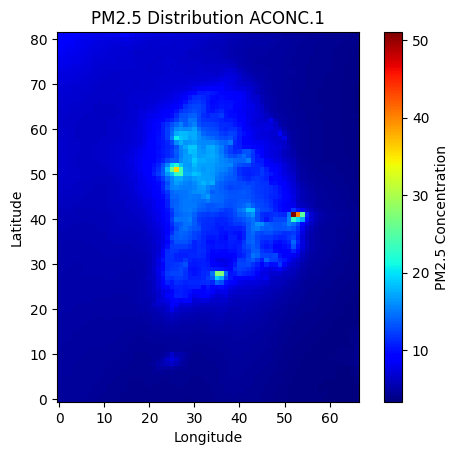

In [8]:
plt.imshow(conc_data_2019_05, origin="lower", cmap='jet')
plt.colorbar(label="PM2.5 Concentration")
plt.title("PM2.5 Distribution ACONC.1")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# netCDF 데이터 제어

In [9]:
# 24시간 concentration map
def load_conc_map(data, sp):
    conc_map = np.zeros((24, 1, 82, 67))
    for key in sp: 
        conc_map += data.variables[key][...]
    return conc_map

# 각 물질별 농도 key 이름
pm25_sp = [
    "ASO4J", "ASO4I",               # ASO4,                 황산염 (J는 조대입자 모드, I는 미세입자 모드),  이산화황이 대기 중 산화하며 형성되는 2차 생성 입자
    "ANH4J", "ANH4I",               # ANH4,                 암모늄,                                         암모니아와 황산염 또는 질산염과 결합하여 생성. 2차 생성 입자의 주요 구성 요소
    "ANO3J", "ANO3I",               # ANO3,                 질산염,                                         질소산화물이 대기중에서 산화되어 형성, 황산염과 함께 PM2.5의 주요 2차 입자 성분
    "ACLJ", "ACLI",                 # ACL,                  염화물,                                         해양 소금이나 산업 배출에서 발생하며 PM2.5의 일부분으로 포함됨
    "AECJ", "AECI",                 # AEC,                  원소 탄소,                                      블랙카본으로 알려짐. 연료 연소에서 발생 (디젤, 화석연료)
    "AORGPAJ", "AORGPAI",           # AORGPA,               1차 유기탄소,                                   연료 연소, 생물학적 활동에서 직접 방출되는 유기 화합물
    "ATRP1J", "ATRP2J",             # ATRP1, ATRP2,         방향족 화합물 유래 유기 에어로졸,               휘발성 유기 화합물(VOC)의 대기 산화 반응으로 생성된 2차 유기 입자
    "AOLGAJ", "AOLGBJ",             # AOLGA, AOLGB,         산화된 유기 화합물 (Organic Acids),             유기 화합물의 대기 산화 반응으로 생성된 산화 유기물
    "AXYL1J", "AXYL2J", "AXYL3J",   # AXYL1, AXYL2, AXYL3,  자일렌 유래 유기 에어로졸,                      VOC의 일종인 자일렌이 대기 중에서 산화되어 생성
    "ATOL1J", "ATOL2J", "ATOL3J",   # ATOL1, ATOL2, ATOL3,  톨루엔 유래 유기 에어로졸,                      VOC의 일종인 톨루엔이 대기 중에서 산화되어 생성
    "ABNZ1J", "ABNZ2J", "ABNZ3J",   # ABNZ1, ABNZ2, ABNZ3,  벤젠 유래 유기 에어로졸,                        VOC의 일종인 벤젠이 산화 반응을 통해 유기 에어로졸로 전환
    "AISO1J", "AISO2J", "AISO3J",   # AISO1, AISO2, AISO3,  이소프렌 유래 유기 에어로졸,                   식물에서 방출되는 VOC로부터 유래된 유기 성분
    "AORGCJ",                       # AORGC,                기타 유기 화합물,                               다양한 출처에서 유래된 유기 화합물
    "AALKJ",                        # AALK,                 알칸 유래 에어로졸,                             알칸류 VOC에서 유래된 입자 성분
    "ASQTJ",                        # ASQT,                 스쿠알렌 유래 에어로졸,                         인간 피부에서 방출되는 천연 화합물로 대기에서 산화되어 생성
    "A25J",                         # A25,                  기타 에어로졸,                                  특정 그룹에 포함되지 않는 2차 에어로졸 성분
    "ANAJ",                         # ANAJ,                 나트륨,                                         해양 소금 또는 산업 활동에서 기원
]

no2_sp = ["NO2"]
o3_sp = ["O3", "O3P"]
so2_sp = ["SO2"]
co_sp = ["CO"]

hourly_sample = Dataset('/home/user/workdir/main/datasets/nc/RSM_1/CCTM_GUIDE_RSM_Linux2_x86_64mpif90.GUIDE.RSM.ACONC.2012357.ncf', 'r')

conc_maps = [
    load_conc_map(hourly_sample, no2_sp),
    load_conc_map(hourly_sample, o3_sp),
    load_conc_map(hourly_sample, so2_sp),
    load_conc_map(hourly_sample, co_sp),
    load_conc_map(hourly_sample, pm25_sp)]

In [10]:
for time in range(0, len(conc_maps[4])):
    pm25_data = conc_maps[4][time].squeeze()
    plt.figure(figsize=(12, 5))
    plt.imshow(pm25_data, origin="lower", cmap='jet')
    plt.colorbar(label="PM2.5 Concentration")
    plt.title(f"PM2.5 Distribution at Time {time}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    
    plt.savefig(f'/mnt/dsk1/mrlee/result/pm25/pm25_{str(time).zfill(4)}.png', bbox_inches='tight')
    plt.close('all')

    print(f'{time+1}/{24}', end='\r')

In [11]:
def create_gif(image_folder, output_gif, resize=True, duration=500):
    images = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')]
    images.sort()
    if not images:
        return
    opened_images = [Image.open(img) for img in images]
    sizes = [img.size for img in opened_images]
    # print("이미지 크기 목록:", sizes)

    if len(set(sizes)) == 1:
        opened_images[0].save(output_gif, save_all=True, append_images=opened_images[1:], duration=duration, loop=0)
    else:
        min_size = (min([w for w, h in sizes]), min([h for w, h in sizes]))
        resized_images = [img.resize(min_size, Image.Resampling.LANCZOS) for img in opened_images]
        resized_images[0].save(output_gif, save_all=True, append_images=resized_images[1:], duration=duration, loop=0)

image_folder = '/mnt/dsk1/mrlee/result/pm25' # PNG 이미지가 저장된 경로
output_gif = '/mnt/dsk1/mrlee/result/pm25/pm25_output.gif' # 생성될 GIF 경로
create_gif(image_folder, output_gif)

# 모델 적용 및 학습 과정

In [12]:
emis_ctrl_2013_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2013.csv', index_col=0)
emis_ctrl_2013_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2013_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :85], ctrl_data[:, 85]
# -------------
base_path_2013 = '/home/user/workdir/main/datasets/concentration/2013'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2013, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['PM2_5'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [13]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/pm25/final_model'  # 모델 저장 경로

epochs = 500  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.3  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

model = build_model(
    ctrl_dim=17*5,                  # 모델 입력, 17 지역(시, 도)과 5개 전구물질 배출량의 결합
    cond_dim=[1],                # timestep과 boundary 조건 입력에 해당하는 속성 크기
    emb_dims=[64],              # 임베딩 레이어의 데이터 차원
    emb_type=['normal'],    # 임베딩 유형
    out_channel=1,                  # target value의 크기
    hidden_size=[64, 96],           # 히든 레이어 출력 크기
    hidden_depth=4,                 # 인코더 및 디코더 레이어 등 히든 레이어 개수
    in_filters=5,                   # 초기 필터의 개수
    kernel_size=3,                  # 컨볼루션 연산에 사용하는 커널(필터) 사이즈
    activation='silu',              # 활성화 함수 유형 (Sigmoid ReLU)
    dropout=0.0,                    # 드롭아웃 수치
    use_abs=True)                   # 모델 출력의 절대값 유/무
'''
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.MeanSquaredError(),)

# define callback
def scheduler(epoch, lr):
    if epoch < 400: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/pm25/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)
'''

"\nmodel.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.MeanSquaredError(),)\n\n# define callback\ndef scheduler(epoch, lr):\n    if epoch < 400: return 1e-3\n    else: return 1e-4\ncallback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)\n\ncallback_ckpt = tf.keras.callbacks.ModelCheckpoint(\n    filepath='/home/user/workdir/main/src/model/pm25/final_model-{epoch:02d}-{val_loss:.2f}',\n    monitor='val_loss',\n    save_best_only=True,\n    save_weights_only=False,\n    mode='min',\n    save_freq='epoch')\n\nhistory = model.fit(\n    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)\n    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)\n    epochs=epochs,\n    batch_size=batch_size,\n    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터\n    callbacks=[callback_lr, callback_ckpt])\nmodel.save(model_path)\n"

In [14]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_loss(history)

NameError: name 'history' is not defined

# 예측 과정 및 결과

In [93]:
# model = tf.keras.models.load_model('/home/user/workdir/main/src/model/pm25/final_model')
# model = tf.keras.models.load_model('/home/user/workdir/main/src/model/pm25/final_model-150-24.63')
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/pm25/final_model-300-0.61')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2019.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['PM2_5'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :85], ctrl_data[:, 85]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 1s 68ms/step


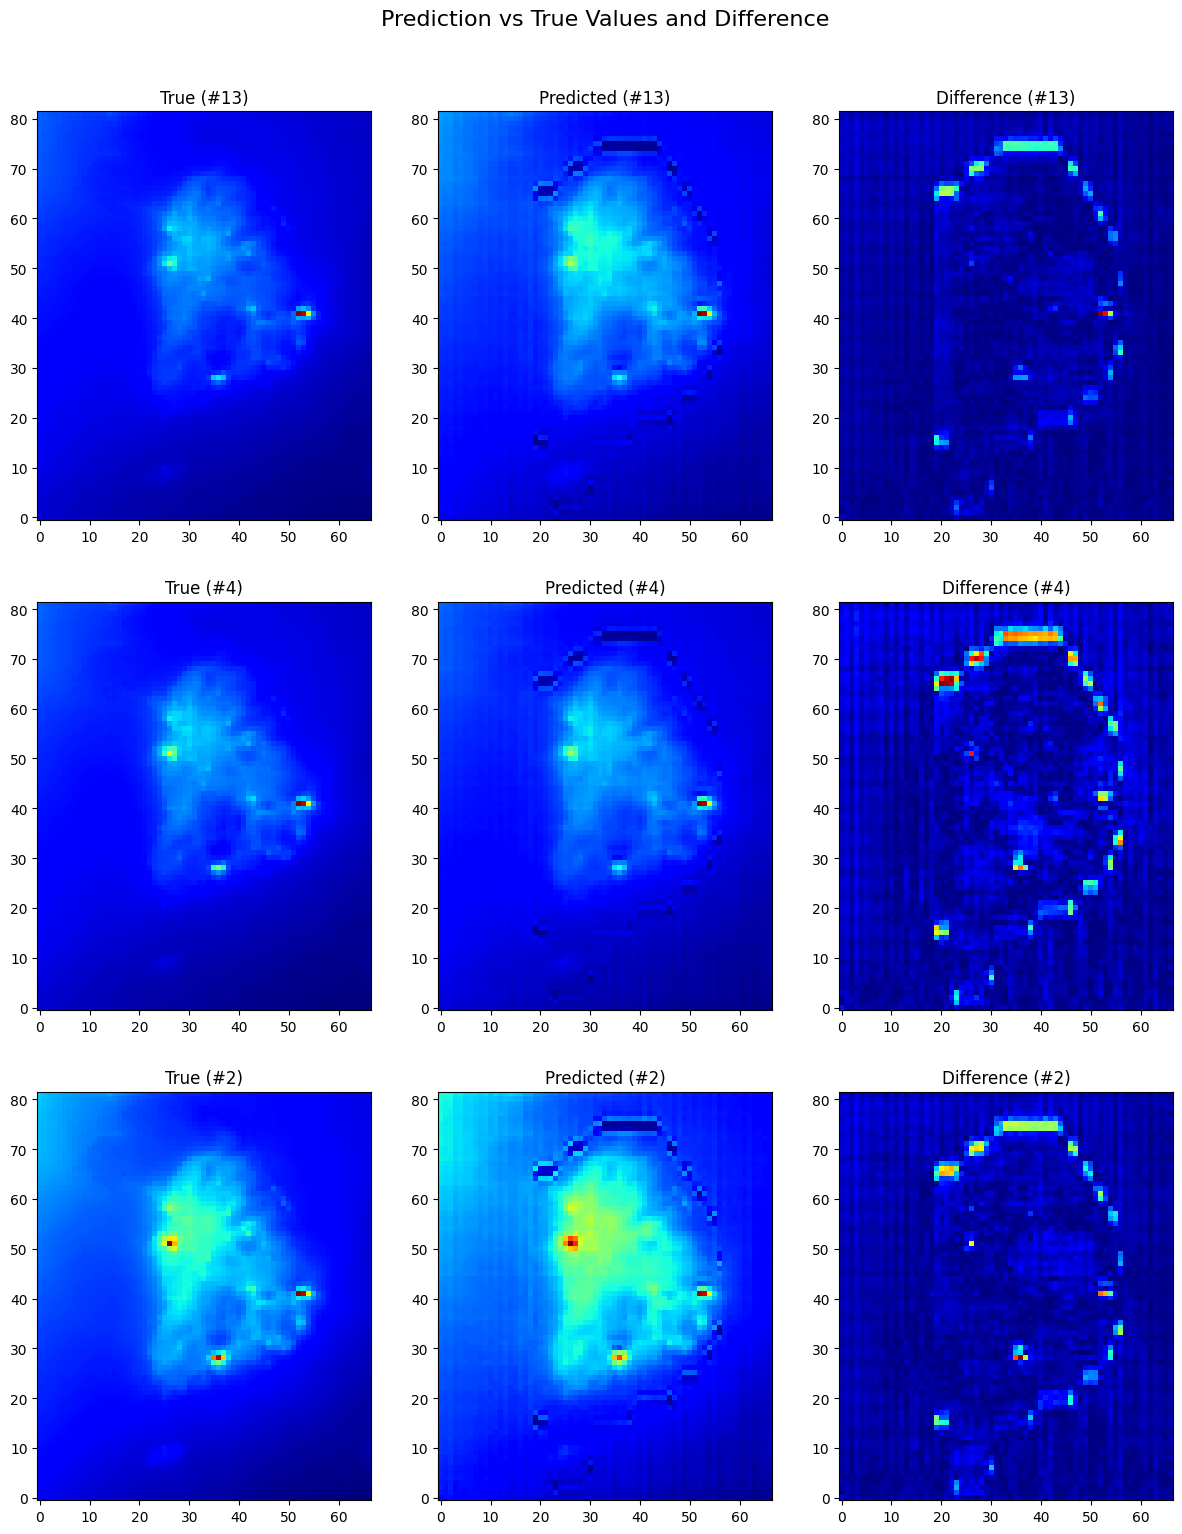

In [94]:
def plot_prediction_loss(y_true, y_pred, num_samples=3):
    indices = np.random.choice(len(y_true), num_samples, replace=False)   
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(y_true[idx], cmap="jet", origin="lower")
        axes[i, 0].set_title(f"True (#{idx})")
        
        # Predicted 이미지
        axes[i, 1].imshow(y_pred[idx], cmap="jet", origin="lower")
        axes[i, 1].set_title(f"Predicted (#{idx})")
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(difference, cmap="jet", origin="lower")
        axes[i, 2].set_title(f"Difference (#{idx})")
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

# plot_prediction_loss(y_true, y_pred, len(y_true))
plot_prediction_loss(y_true, y_pred)

# 한국 영토 구성에 맞게 Grid Cell 구조 설정

In [17]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅

proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')


# 예측 값 Concentration Map 출력

In [18]:
# idx번째 sample conc. map 출력
pm25_conc_map_w_lines = np.where(mask==1, y_pred[24], 0)[::-1]

/tmp/ipykernel_861407/814967754.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_861407/814967754.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])


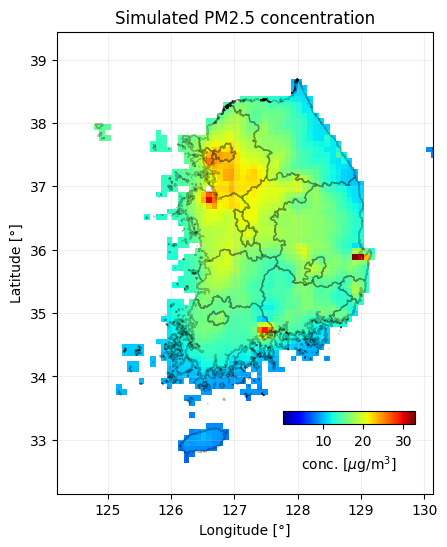

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.imshow(
    pm25_conc_map_w_lines,
    cmap=cmap_white,
    extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
    vmin=0.001)
axes = ctprvn_proj.boundary.plot(ax=axes, edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
axes.set_xlim(-180000, 414000)
axes.set_ylim(-585000, 144000)
axes.set_title(f'Simulated PM2.5 concentration')
axes.set_xlabel('Longitude [°]')
axes.set_ylabel('Latitude [°]')
axes.grid(alpha=0.25, color='silver')
axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])
cbaxes = axes.inset_axes([0.6, 0.15, 0.35, 0.03])
cb = plt.colorbar(axes.images[0], cax=cbaxes, orientation='horizontal', label='PM2.5 ($\mu g/m^3$)')
cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
plt.show()

# N일 예측 결과에 대한 24시간 PM2.5 농도 변화 영상

In [39]:
def predict_hourly(models, emis, time, boundary):
    date = np.repeat(time, 24, axis=0)
    print('time.shape:',date.shape)
    bnd = np.repeat(boundary, 24, axis=0)
    print('boundary.shape:',bnd.shape)
    ctrl = np.repeat(emis, 24, axis=0)
    print('emis.shape:',ctrl.shape)
    y_preds = models.predict([ctrl, date, bnd])

    return y_preds

In [ ]:
emis_ctrl_day_05 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2019.csv', index_col=0)
emis_ctrl_day_05 = emis_ctrl_day_05.iloc[:40]
emis_ctrl_day_05['Timestep'] = 0.0
emis_ctrl_day_05['Boundary'] = 0.5

emis_ctrl_day_05 = emis_ctrl_day_05.values

emis, time, boundary = emis_ctrl_day_05[:, :85], emis_ctrl_day_05[:, 85], emis_ctrl_day_05[:, 86]

y_preds = predict_hourly(model, emis, time, boundary)

In [ ]:
days = 40
hours = 24

for time in range(0, days*hours):
    fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=150, clear=True)

    axes.imshow(
        y_preds[time][::-1],
        cmap='GnBu',
        interpolation='bilinear',
        extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y))
    # plt.colorbar(axes.images[0], label='PM2.5 ($\mu g/m^3$)', ax=axes)
    axes = ctprvn_proj.boundary.plot(ax=axes, edgecolor='grey', facecolor='none', linewidth=1, alpha=0.25)
    axes.set_xlim(-180000, 414000)
    axes.set_ylim(-585000, 144000)
    axes.set_title("PM2.5 [$\Delta C$] for 40 Days")
    axes.set_xlabel('Longitude [°]')
    axes.set_ylabel('Latitude [°]')
    axes.grid(alpha=0.25, color='silver')
    axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
    axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])
    
    plt.savefig(f'/mnt/dsk1/mrlee/result/figure/PM25/PM25_{str(time).zfill(4)}.png', bbox_inches='tight')
    plt.close('all')

    print(f'{time+1}/{days*hours}', end='\r')

In [ ]:
from moviepy import ImageSequenceClip

# PNG 파일 리스트 가져오기
import os

img_path = '/mnt/dsk1/mrlee/result/figure/PM25'
png_files = sorted([f for f in os.listdir(img_path) if f.endswith('.png')])

# 이미지 시퀀스를 비디오로 변환
clip = ImageSequenceClip([os.path.join(img_path, f) for f in png_files], fps=30)
clip.write_videofile("pm25_output_40days.mp4", codec="libx264", fps=30, preset="medium", bitrate="800k")


# 추가 실험 결과 도출

## Image Figure (PM2.5)

In [110]:
test_split = 0.2  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/pm25/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2019.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['PM2_5'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :85], ctrl_data[:, 85]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test])
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

1/1 [==============================] - 1s 510ms/step


In [112]:
# idx번째 sample conc. map 출력
pred_conc_map_w_lines = np.where(mask==1, y_pred[23], 0)[::-1]
true_conc_map_w_lines = np.where(mask==1, y_true[23], 0)[::-1]

/tmp/ipykernel_861407/814967754.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_861407/814967754.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])


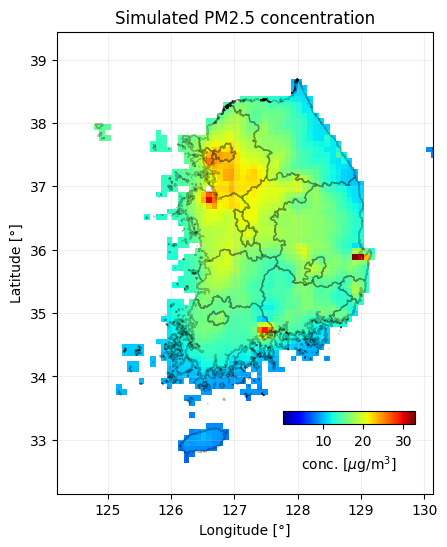

In [113]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.imshow(
    pm25_conc_map_w_lines,
    cmap=cmap_white,
    extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
    vmin=0.001)
axes = ctprvn_proj.boundary.plot(ax=axes, edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
axes.set_xlim(-180000, 414000)
axes.set_ylim(-585000, 144000)
axes.set_title(f'Simulated PM2.5 concentration')
axes.set_xlabel('Longitude [°]')
axes.set_ylabel('Latitude [°]')
axes.grid(alpha=0.25, color='silver')
axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])
cbaxes = axes.inset_axes([0.6, 0.15, 0.35, 0.03])
cb = plt.colorbar(axes.images[0], cax=cbaxes, orientation='horizontal', label='PM2.5 ($\mu g/m^3$)')
cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
plt.show()

/tmp/ipykernel_861407/3903238057.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_861407/3903238057.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])


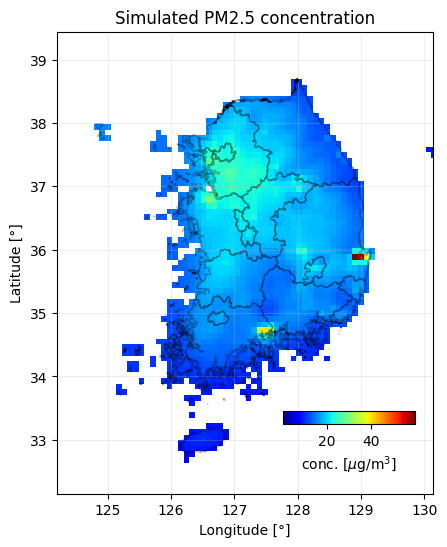

In [114]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.imshow(
    true_conc_map_w_lines,
    cmap=cmap_white,
    extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
    vmin=0.001)
axes = ctprvn_proj.boundary.plot(ax=axes, edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
axes.set_xlim(-180000, 414000)
axes.set_ylim(-585000, 144000)
axes.set_title(f'Simulated PM2.5 concentration')
axes.set_xlabel('Longitude [°]')
axes.set_ylabel('Latitude [°]')
axes.grid(alpha=0.25, color='silver')
axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])
cbaxes = axes.inset_axes([0.6, 0.15, 0.35, 0.03])
cb = plt.colorbar(axes.images[0], cax=cbaxes, orientation='horizontal', label='PM2.5 ($\mu g/m^3$)')
cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
plt.show()

In [125]:
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

y_true = true_conc_map_w_lines.reshape(-1)
y_pred = pred_conc_map_w_lines.reshape(-1)

(82, 67)
(82, 67)


# ----

In [130]:
def ioa_score(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((np.abs(y_pred - np.mean(y_true)) + np.abs(y_true - np.mean(y_true))) ** 2)

def nmae_score(y_true, y_pred):
    return np.mean(np.abs(y_true + 1e-7 - y_pred) / np.abs(y_true + 1e-7))

def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=200, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
#    ioa = ioa_score(y_true, y_pred)
#    rmse = mean_squared_error(y_true, y_pred)
#    nmae = nmae_score(y_true, y_pred)
    # add text
    ax.text(
#        0.05, 0.90, f"$R^2={r2:.4f}$ \IOA={ioa:.4f}\nMSE={rmse:.4f}\nNMAE={nmae:.4f}",
        0.05, 0.90, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=10
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

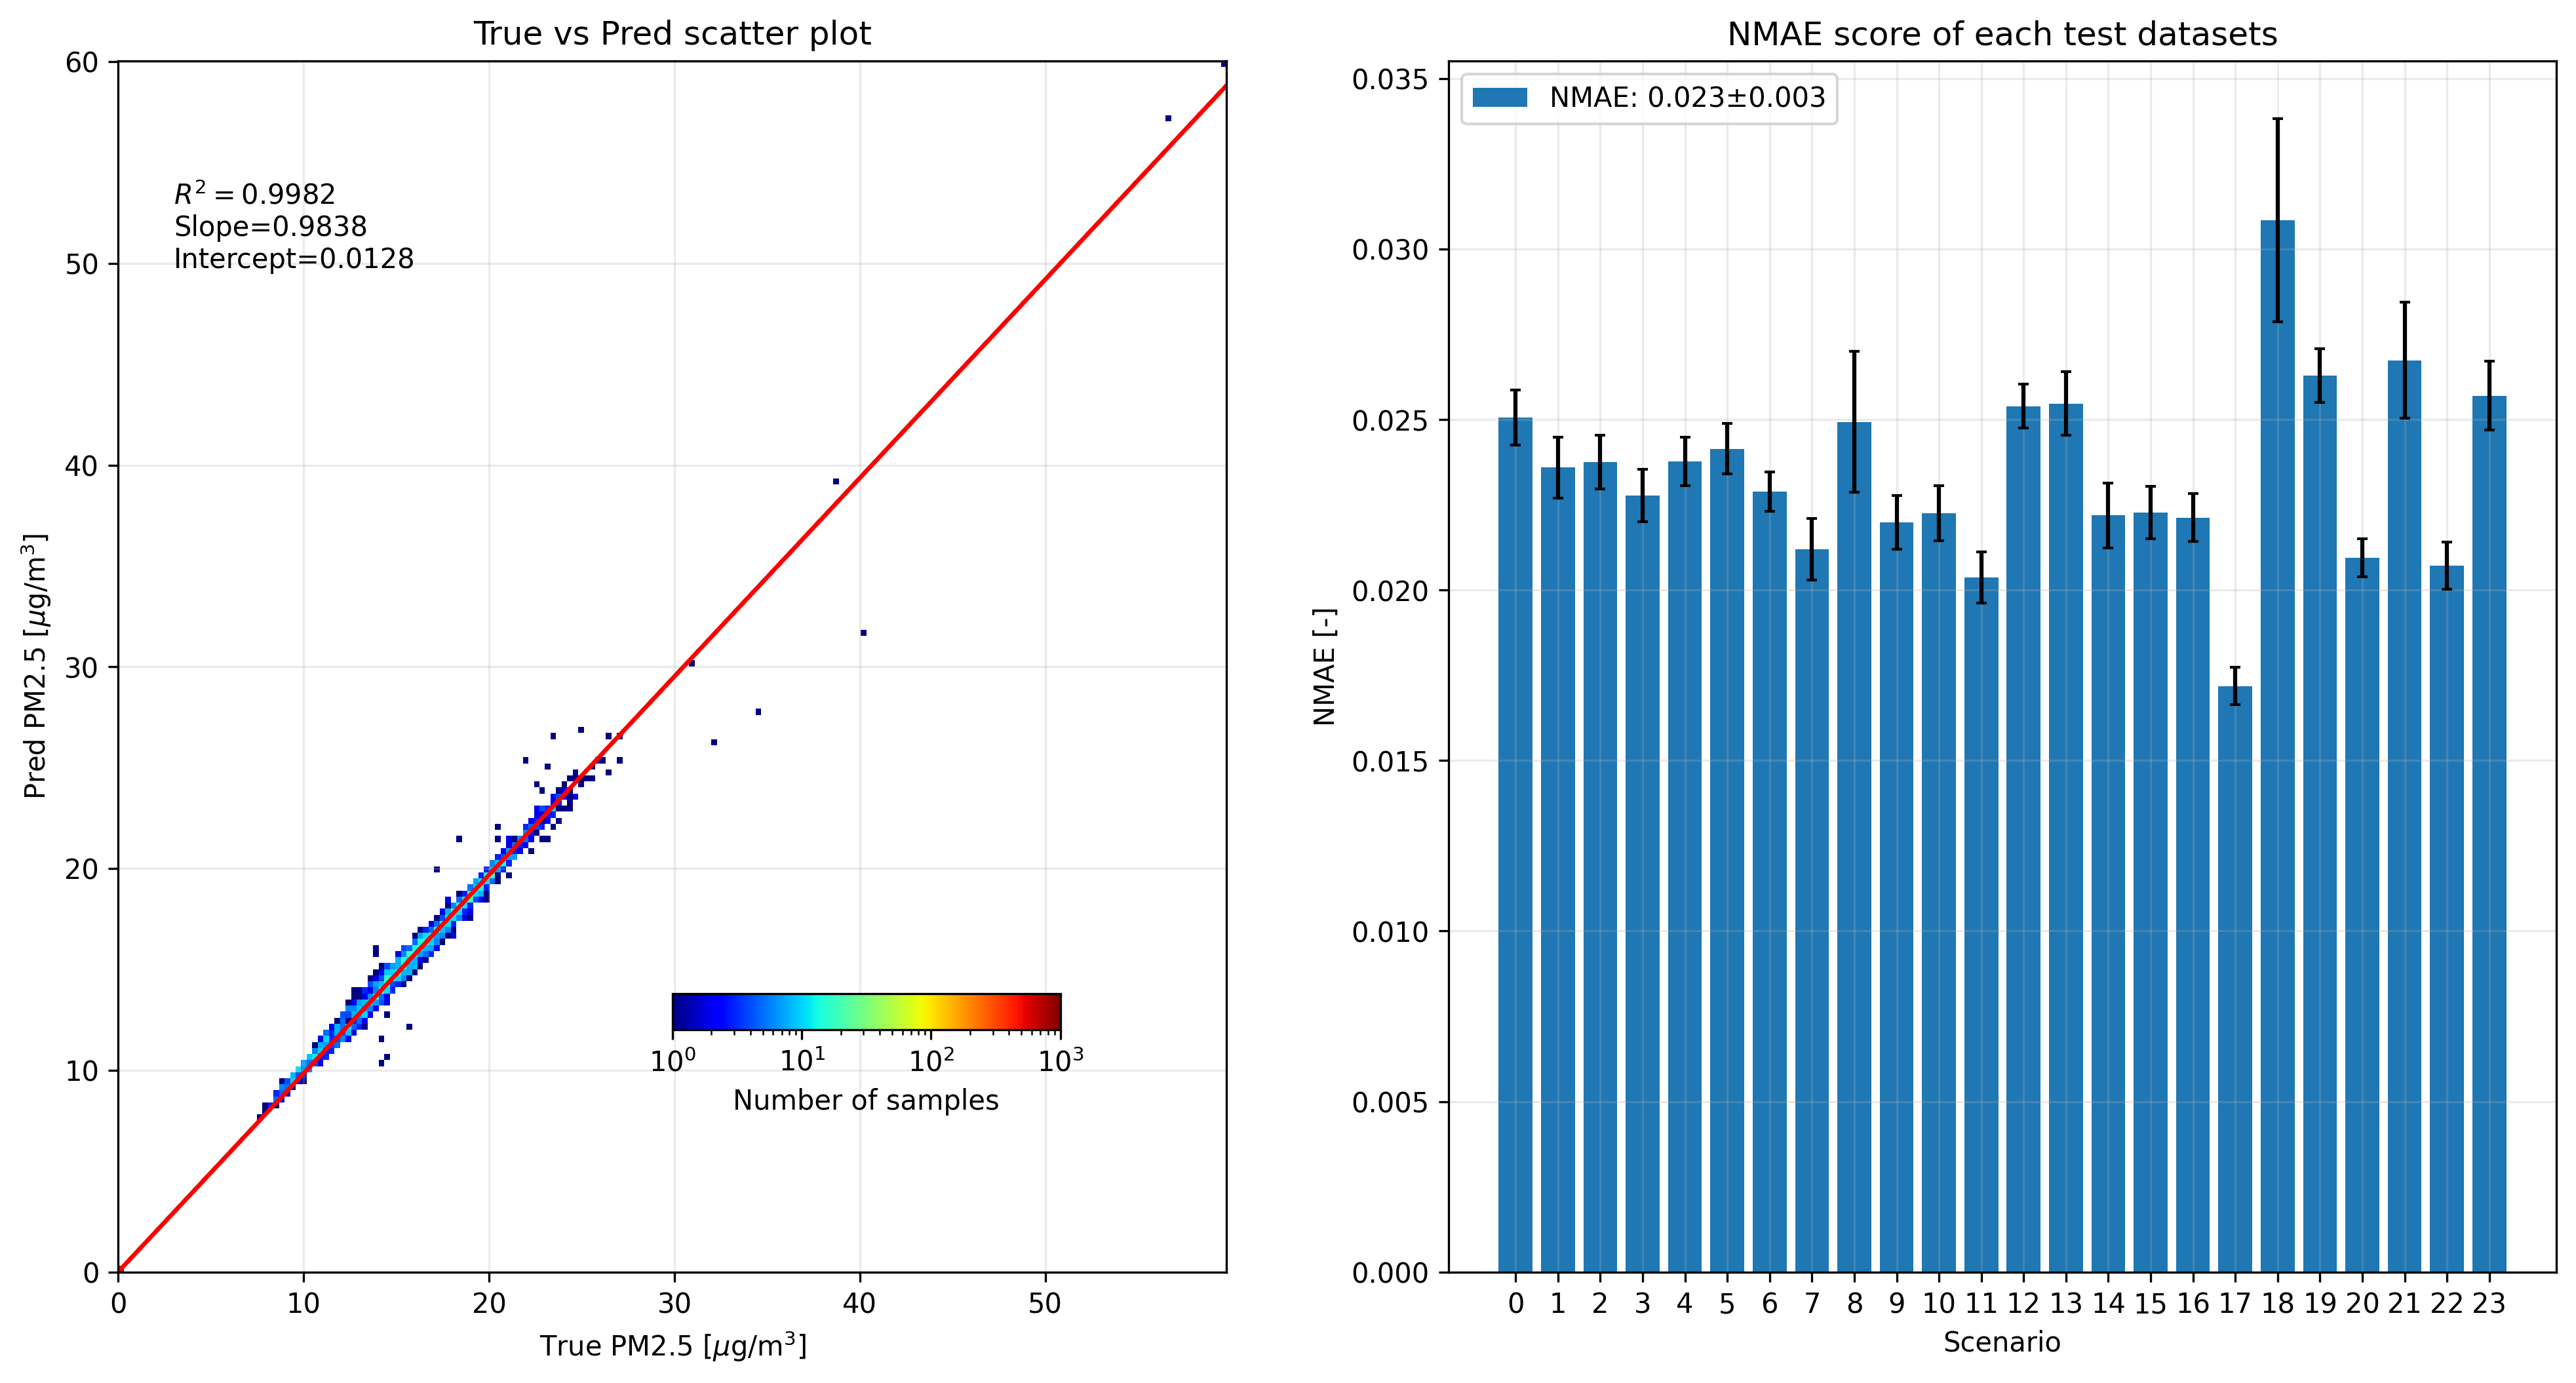

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=300)
axes[0] = plot_scatter(axes[0], true_conc_map_w_lines.reshape(-1), pred_conc_map_w_lines.reshape(-1))
axes[0].grid(alpha=0.25)
axes[0].set_title("True vs Pred scatter plot")
axes[0].set_xlabel('True PM2.5 [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred PM2.5 [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true = y_test.reshape(y_test.shape[0], -1)
y_pred = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true, y_pred)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes[1].legend()
axes[1].grid(alpha=0.25)
axes[1].set_title("NMAE score of each test datasets")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [-]')
plt.show()